In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection
import matplotlib.colors as mcolors
import pandas as pd
from scipy import interpolate


In [12]:
FILE_PATH = globals()['_dh'][0]
CODES_LOC = FILE_PATH.parent
AUG2022_LOC = FILE_PATH.parent.parent
DYNDAT_LOC = os.path.join(AUG2022_LOC, "MLmodels", "Dynamic1_Jan2023", "labels")
DYNPRED_LOC = os.path.join(AUG2022_LOC, "MLmodels", "Dynamic1_Jan2023", "predictions", "state")

line_colors = ['tab:blue', 'tab:brown', 'tab:green', 'tab:purple']
dot_colors = ['blue', 'orangered', 'green', 'crimson']
x_lims = [600, 800, 800, 700]

In [3]:
def export_plot(filenamebase, export_area_drawing = True, export_latex = True):

  plt.savefig("{}_l.pdf".format(filenamebase))

  if export_latex:
    ead = ''
    if export_area_drawing:
      ead = '--export-area-drawing'

    el = '--export-latex'
    plt.savefig("{}.svg".format(filenamebase))
    cmd = ''' env -u LD_LIBRARY_PATH inkscape -T -f {0}.svg \
              --export-background-opacity=0 \
              {1} {2} --export-pdf={0}.pdf'''.format(filenamebase, ead, el)
    os.system(cmd)
    os.system('rm {}.svg'.format(filenamebase))

In [4]:
%matplotlib widget

In [ ]:
#Plot measurements of dynamic runs in a variable width line plot

fig, ax = plt.subplots()
for i in range(4):
  dyn_file = open(os.path.join(DYNDAT_LOC, f"dynamic1_run{i+15}_truth.pkl"), "rb")
  dyn_data = pickle.load(dyn_file)
    
  x_axis = dyn_data["Video Time (sec)"].iloc[0:-1]
  aoa_exp = dyn_data["WT_AoA"].iloc[0:-1]
  vel_exp = dyn_data["WT_Airspeed"].iloc[0:-1]
  # vel_exp [vel_exp < 0] = 0

  x_new = np.linspace(x_axis.iloc[0], x_axis.iloc[-1], int(len(x_axis)*10))
  
  # aoa_new = np.interp(x_new, x_axis, aoa_exp)
  # vel_new = np.interp(x_new, x_axis, vel_exp)

  # aoa_bspline = interpolate.make_interp_spline(x_axis, aoa_exp, k=5)
  # vel_bspline = interpolate.make_interp_spline(x_axis, vel_exp, k=5)
  aoa_bspline = interpolate.make_smoothing_spline(x_axis, aoa_exp, lam=0.1)
  vel_bspline = interpolate.make_smoothing_spline(x_axis, vel_exp, lam=0.1)
  aoa_new = aoa_bspline(x_new)
  vel_new = vel_bspline(x_new)

  points = np.array([x_new, aoa_new]).T.reshape(-1,1,2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)

  color_mask = np.where((vel_new < 7, vel_new > 20, aoa_new < 0, aoa_new > 16), 1, 0).any(axis=0)
  color_mask = color_mask.astype('<U10')
  color_mask [color_mask == "True"] = 'red'
  color_mask [color_mask == "False"] = line_colors[i]

  lc = LineCollection(segments, color=line_colors[i], alpha=0.8, label=f"Exp {i+1}", linewidths=vel_new)
  
  ax.add_collection(lc)
  
ax.set_xlim(0, 800)
ax.set_ylim(-2, 20)

leg = ax.legend(loc='upper left', fontsize="12")
for i in range(4):
  leg.legendHandles[i].set_color(line_colors[i])
  leg.legendHandles[i].set_linewidth(2)
  
ax.tick_params(axis="both", which="major", labelsize=13)
plt.locator_params(axis='both', nbins=5)
plt.xlabel("Time (sec)", fontsize=15)
plt.ylabel("AoA (deg)", fontsize=15)

plt.tight_layout()


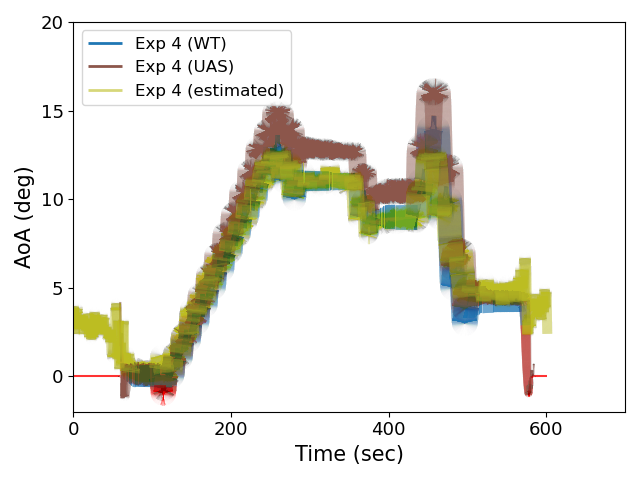

In [16]:
#(Airspeed/AoA) Plot WT measurement vs UAV measurement vs predictions of dynamic runs in a variable width line plot
fig, ax = plt.subplots()
for i in range(3,4):
  dyn_file_measurements = open(os.path.join(DYNDAT_LOC, f"dynamic1_run{i+15}_truth.pkl"), "rb")
  dyn_data_measurements = pickle.load(dyn_file_measurements)
  dyn_data_predictions = np.load(os.path.join(DYNPRED_LOC, f"dynamic1_run{i+15}_model_fno1d_valSplit_preds.npy"))

  # Take in WT data  
  x_axis = dyn_data_measurements["Video Time (sec)"].iloc[0:-1]
  wt_aoa_meas = dyn_data_measurements["WT_AoA"].iloc[0:-1]
  wt_vel_meas = dyn_data_measurements["WT_Airspeed"].iloc[0:-1]

  # Fix the sudden jumps in UAV data
  problem_rows = dyn_data_measurements[dyn_data_measurements["UAV_Alpha"] > 5].index
  dyn_data_measurements["UAV_Alpha"][problem_rows] = np.NaN
  dyn_data_measurements["UAV_TAS"][problem_rows] = np.NaN
  dyn_data_measurements.ffill(inplace=True)
  # Fix zero divisions in UAV data
  dyn_data_measurements["UAV_Alpha"].iloc[0:-1][wt_vel_meas < 2] = 0
  dyn_data_measurements["UAV_TAS"].iloc[0:-1][wt_vel_meas < 2] = 0

  # Take in UAV data
  uav_aoa_meas = dyn_data_measurements["UAV_Alpha"].iloc[0:-1]
  uav_aoa_meas = uav_aoa_meas * 180 / np.pi
  uav_vel_meas = dyn_data_measurements["UAV_TAS"].iloc[0:-1]
  # uav_aoa_meas = dyn_data_measurements["UAV_Pitch"].iloc[0:-1]
  # uav_aoa_meas += 2.5
  
  # Take in predict data
  aoa_pred = dyn_data_predictions[:,1]
  vel_pred = dyn_data_predictions[:,0]

  x_new = np.linspace(x_axis.iloc[0], x_axis.iloc[-1], int(len(x_axis)*10))
  
  # Alternative interpolation method (not great!)
  # aoa_new = np.interp(x_new, x_axis, aoa_exp)
  # vel_new = np.interp(x_new, x_axis, vel_exp)
  # aoa_bspline = interpolate.make_interp_spline(x_axis, aoa_exp, k=5)
  # vel_bspline = interpolate.make_interp_spline(x_axis, vel_exp, k=5)
  
  wt_aoa_bspline_meas = interpolate.make_smoothing_spline(x_axis, wt_aoa_meas, lam=0.1)
  wt_vel_bspline_meas = interpolate.make_smoothing_spline(x_axis, wt_vel_meas, lam=0.1)
  wt_aoa_new_meas = wt_aoa_bspline_meas(x_new)
  wt_vel_new_meas = wt_vel_bspline_meas(x_new)

  uav_aoa_bspline_meas = interpolate.make_smoothing_spline(x_axis, uav_aoa_meas, lam=0.1)
  uav_vel_bspline_meas = interpolate.make_smoothing_spline(x_axis, uav_vel_meas, lam=0.1)
  uav_aoa_new_meas = uav_aoa_bspline_meas(x_new)
  uav_vel_new_meas = uav_vel_bspline_meas(x_new)

  aoa_bspline_pred = interpolate.make_smoothing_spline(x_axis, aoa_pred, lam=0.1)
  vel_bspline_pred = interpolate.make_smoothing_spline(x_axis, vel_pred, lam=0.1)
  aoa_new_pred = aoa_bspline_pred(x_new)
  vel_new_pred = vel_bspline_pred(x_new)

  wt_points_meas = np.array([x_new, wt_aoa_new_meas]).T.reshape(-1,1,2)
  uav_points_meas = np.array([x_new, uav_aoa_new_meas]).T.reshape(-1,1,2)
  points_pred = np.array([x_new, aoa_new_pred]).T.reshape(-1,1,2)
  
  segments_wt_meas = np.concatenate([wt_points_meas[:-1], wt_points_meas[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)
  segments_uav_meas = np.concatenate([uav_points_meas[:-1], uav_points_meas[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)
  segments_pred = np.concatenate([points_pred[:-1], points_pred[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)
  
  color_mask = np.where((wt_vel_new_meas < 7, wt_vel_new_meas > 20, wt_aoa_new_meas < -0.5, wt_aoa_new_meas > 16), 1, 0).any(axis=0)
  color_mask = color_mask.astype('<U10')
  color_mask [color_mask == "True"] = 'red'
  color_mask [color_mask == "False"] = 'tab:blue'

  lc_wt_meas = LineCollection(segments_wt_meas, color=color_mask, alpha=0.8, label=f"Exp {i+1} (WT)", linewidths=wt_vel_new_meas)
  lc_uav_meas = LineCollection(segments_uav_meas, color='tab:brown', alpha=0.6, label=f"Exp {i+1} (UAS)", linewidths=uav_vel_new_meas)
  lc_pred = LineCollection(segments_pred, color='tab:olive', alpha=0.6, label=f"Exp {i+1} (estimated)", linewidths=vel_new_pred)
  
  ax.add_collection(lc_wt_meas)
  ax.add_collection(lc_uav_meas)
  ax.add_collection(lc_pred)
  
  ax.set_xlim(0, x_lims[i])
  ax.set_ylim(-2, 20)
  
  leg = ax.legend(loc='upper left', fontsize="12")
  leg.legendHandles[0].set_color('tab:blue') #WT
  leg.legendHandles[1].set_color('tab:brown') #UAV
  leg.legendHandles[0].set_linewidth(2)
  leg.legendHandles[1].set_linewidth(2)
  leg.legendHandles[2].set_linewidth(2)
  
  ax.tick_params(axis="both", which="major", labelsize=13)
  plt.locator_params(axis='both', nbins=5)
  plt.xlabel("Time (sec)", fontsize=15)
  plt.ylabel("AoA (deg)", fontsize=15)

  plt.tight_layout()

  # fig.show()
  fig.savefig(f"dyn{i+1}_measVSpredVSuav_v2.png", dpi=300)

In [14]:
dyn_data_predictions.shape

(22798, 2)

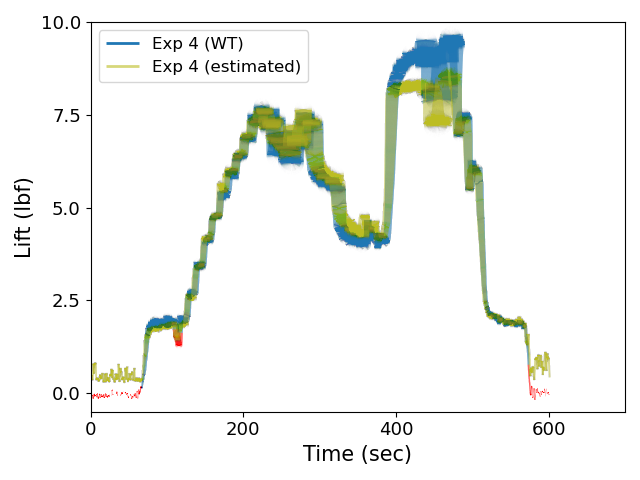

In [20]:
#(Lift/Drag) Plot WT measurement vs predictions of dynamic runs in a variable width line plot
DYNPRED_LOC = os.path.join(AUG2022_LOC, "MLmodels", "Dynamic1_Jan2023", "predictions", "liftdrag")
fig, ax = plt.subplots()
for i in range(3,4):
  dyn_file_measurements = open(os.path.join(DYNDAT_LOC, f"dynamic1_run{i+15}_truth_nopeaks.pkl"), "rb")
  dyn_data_measurements = pickle.load(dyn_file_measurements)
  dyn_data_predictions = np.load(os.path.join(DYNPRED_LOC, f"dynamic1_run{i+15}_model_fno1d_valSplit_LiftDrag_preds_nopeaks.npy"))

  # Take in WT data  
  x_axis = dyn_data_measurements["Video Time (sec)"].iloc[0:-1]
  wt_aoa_meas = dyn_data_measurements["WT_AoA"].iloc[0:-1]
  wt_vel_meas = dyn_data_measurements["WT_Airspeed"].iloc[0:-1]
  wt_lift_meas = dyn_data_measurements["Lift (lbf)"].iloc[0:-1]
  wt_drag_meas = dyn_data_measurements["Drag (lbf)"].iloc[0:-1]
  
  # Take in predict data
  drag_pred = dyn_data_predictions[:,1]
  lift_pred = dyn_data_predictions[:,0]

  x_new = np.linspace(x_axis.iloc[0], x_axis.iloc[-1], int(len(x_axis)*10))
  
  wt_aoa_bspline_meas = interpolate.make_smoothing_spline(x_axis, wt_aoa_meas, lam=0.1)
  wt_vel_bspline_meas = interpolate.make_smoothing_spline(x_axis, wt_vel_meas, lam=0.1)
  wt_lift_bspline_meas = interpolate.make_smoothing_spline(x_axis, wt_lift_meas, lam=0.1)
  wt_drag_bspline_meas = interpolate.make_smoothing_spline(x_axis, wt_drag_meas, lam=0.1)
  wt_aoa_new_meas = wt_aoa_bspline_meas(x_new)
  wt_vel_new_meas = wt_vel_bspline_meas(x_new)
  wt_lift_new_meas = wt_lift_bspline_meas(x_new)
  wt_drag_new_meas = wt_drag_bspline_meas(x_new)

  lift_bspline_pred = interpolate.make_smoothing_spline(x_axis, lift_pred, lam=0.1)
  drag_bspline_pred = interpolate.make_smoothing_spline(x_axis, drag_pred, lam=0.1)
  lift_new_pred = lift_bspline_pred(x_new)
  drag_new_pred = drag_bspline_pred(x_new)

  wt_points_meas = np.array([x_new, wt_lift_new_meas]).T.reshape(-1,1,2)
  points_pred = np.array([x_new, lift_new_pred]).T.reshape(-1,1,2)
  
  segments_wt_meas = np.concatenate([wt_points_meas[:-1], wt_points_meas[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)
  segments_pred = np.concatenate([points_pred[:-1], points_pred[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)
  
  color_mask = np.where((wt_vel_new_meas < 7, wt_vel_new_meas > 20, wt_aoa_new_meas < -0.5, wt_aoa_new_meas > 16), 1, 0).any(axis=0)
  color_mask = color_mask.astype('<U10')
  color_mask [color_mask == "True"] = 'red'
  color_mask [color_mask == "False"] = 'tab:blue'

  lc_wt_meas = LineCollection(segments_wt_meas, color=color_mask, alpha=0.8, label=f"Exp {i+1} (WT)", linewidths=wt_drag_new_meas*8)
  lc_pred = LineCollection(segments_pred, color='tab:olive', alpha=0.6, label=f"Exp {i+1} (estimated)", linewidths=drag_new_pred*8)
  
  ax.add_collection(lc_wt_meas)
  ax.add_collection(lc_pred)
  
  ax.set_xlim(0, x_lims[i])
  ax.set_ylim(-0.5, 10)
  
  leg = ax.legend(loc='upper left', fontsize="12")
  leg.legendHandles[0].set_color('tab:blue') #WT
  leg.legendHandles[0].set_linewidth(2)
  leg.legendHandles[1].set_linewidth(2)
  
  ax.tick_params(axis="both", which="major", labelsize=13)
  plt.locator_params(axis='both', nbins=5)
  plt.xlabel("Time (sec)", fontsize=15)
  plt.ylabel("Lift (lbf)", fontsize=15)

  plt.tight_layout()

  # fig.show()
  fig.savefig(f"dyn{i+1}_measVSpred_liftdrag_v2.png", dpi=300)

In [7]:
%matplotlib widget

/Users/tanay/miniconda3/envs/python310_tf/lib/python3.10/site-packages/matplotlib/lines.py:1157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
/Users/tanay/miniconda3/envs/python310_tf/lib/python3.10/site-packages/matplotlib/axis.py:124: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


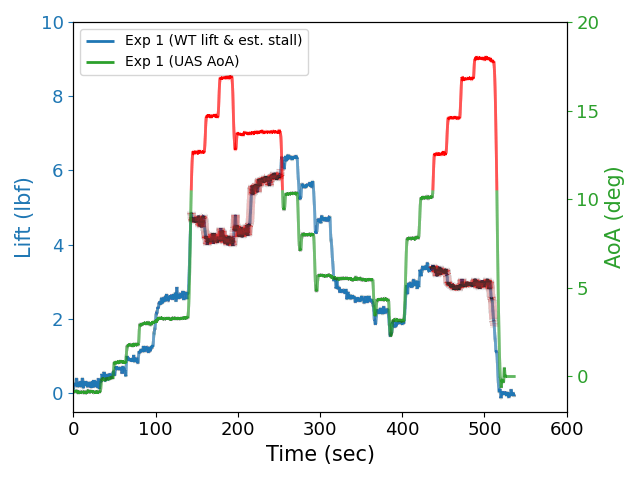

In [10]:
#(Stall) Evaluate stall prediction as follows:
# 1) Plot WT Lift (solid blue).
# 2) (ground truth) Mark the stall onset point according to the lift reduction criterion below
# 3) (industry standard) Plot UAV AoA. The curve is in red when Stall is assumed according to the AoA threshold criterion (explained below).
# 4) (our prediction) On the ground truth curve, plot a thicker 50% transparency yellow curve where we predict stall.

# Lift reduction criterion:
# In WT data, if lift at t1<t0 and t2<t1 while neither of airspeed or AoA at t2 not less than t0, then t1 is marked as stall onset.

#AoA threshold criterion:
# In UAV data, if AoA > 10.5, mark as stall.
DYNPRED_LOC = os.path.join(AUG2022_LOC, "MLmodels", "Dynamic1_Jan2023", "predictions", "stall")
fig, ax = plt.subplots()
for i in range(0,1):
  dyn_file_measurements = open(os.path.join(DYNDAT_LOC, f"dynamic1_run{i+15}_truth_nopeaks.pkl"), "rb")
  dyn_data_measurements = pickle.load(dyn_file_measurements)
  dyn_data_predictions = np.load(os.path.join(DYNPRED_LOC, f"dynamic1_run{i+15}_model_stall_1DCNN_ph10_preds.npy"))

  # Take in WT data  
  x_axis = dyn_data_measurements["Video Time (sec)"].iloc[0:-1]
  wt_aoa_meas = dyn_data_measurements["WT_AoA"].iloc[0:-1]
  wt_vel_meas = dyn_data_measurements["WT_Airspeed"].iloc[0:-1]
  wt_lift_meas = dyn_data_measurements["Lift (lbf)"].iloc[0:-1]
  
  # Fix the sudden jumps in UAV data
  problem_rows = dyn_data_measurements[dyn_data_measurements["UAV_Alpha"] > 5].index
  dyn_data_measurements["UAV_TAS"][problem_rows] = np.NaN
  dyn_data_measurements["UAV_Alpha"][problem_rows] = np.NaN
  dyn_data_measurements.ffill(inplace=True)
  # Fix zero divisions in UAV data
  dyn_data_measurements["UAV_TAS"].iloc[0:-1][wt_vel_meas < 2] = 0
  dyn_data_measurements["UAV_Alpha"].iloc[0:-1][wt_vel_meas < 2] = 0
  # Take in UAV data
  uav_vel_meas = dyn_data_measurements["UAV_TAS"].iloc[0:-1]
  uav_aoa_meas = dyn_data_measurements["UAV_Alpha"].iloc[0:-1]
  uav_aoa_meas = uav_aoa_meas * 180 / np.pi
  
  # Take in predict data
  stall_pred = dyn_data_predictions

  # Create the lift-based stall criterion (not working)
  # wt_lift_meas_shift_1 = wt_lift_meas.shift(-4, fill_value=0)
  # wt_lift_meas_shift_2 = wt_lift_meas.shift(-8, fill_value=0)
  # wt_vel_meas_shift_2 = wt_vel_meas.shift(-4, fill_value=0)
  # wt_aoa_meas_shift_2 = wt_aoa_meas.shift(-4, fill_value=0)
  # wt_lift_compare_df = pd.DataFrame(data=({"lift_s0":wt_lift_meas, "lift_s1":wt_lift_meas_shift_1, "lift_s2":wt_lift_meas_shift_2, 
  #                                         "vel_s0":wt_vel_meas, "vel_s2":wt_vel_meas_shift_2,
  #                                         "aoa_s0":wt_aoa_meas, "aoa_s2":wt_aoa_meas_shift_2}))
  # wt_lift_compare_df['is_stall'] = (wt_lift_compare_df["lift_s1"] < wt_lift_compare_df["lift_s0"]) &\
  #                                 (wt_lift_compare_df["lift_s2"] < wt_lift_compare_df["lift_s1"]) &\
  #                                 (wt_lift_compare_df["vel_s2"] > wt_lift_compare_df["vel_s0"]) &\
  #                                 (wt_lift_compare_df["aoa_s2"] > wt_lift_compare_df["aoa_s0"])
  # print (np.nonzero(wt_lift_compare_df['is_stall'].sum()))

  #Create segments for variable line color
  x_new = np.linspace(x_axis.iloc[0], x_axis.iloc[-1], int(len(x_axis)*10))

  wt_lift_bspline_meas = interpolate.make_smoothing_spline(x_axis, wt_lift_meas, lam=0.1)  
  wt_lift_new_meas = wt_lift_bspline_meas(x_new)
  wt_points_lift_meas = np.array([x_new, wt_lift_new_meas]).T.reshape(-1,1,2)
  segments_wt_lift_meas = np.concatenate([wt_points_lift_meas[:-1], wt_points_lift_meas[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)

  uav_aoa_bspline_meas = interpolate.make_smoothing_spline(x_axis, uav_aoa_meas, lam=0.1)  
  uav_aoa_new_meas = uav_aoa_bspline_meas(x_new)
  uav_points_aoa_meas = np.array([x_new, uav_aoa_new_meas]).T.reshape(-1,1,2)
  segments_uav_aoa_meas = np.concatenate([uav_points_aoa_meas[:-1], uav_points_aoa_meas[1:]], axis=1) #shape:(len(aoa_exp)-1, 2, 2)

  # Repeat stall data to make it compatible with line segments
  stall_new_pred = np.repeat(stall_pred, 10)

  # Align lift-based stall criterion with lift curve.
  # stall_lift_criterion_locs = wt_lift_compare_df [wt_lift_compare_df['is_stall']].index
  # stall_lift_criterion_locs *= 10
  # stall_init_x = [i[0][0] for i in segments_wt_lift_meas[stall_lift_criterion_locs]]
  # stall_init_y = [i[0][1] for i in segments_wt_lift_meas[stall_lift_criterion_locs]]

  # Assign colors and transparency for prediction visualization
  uav_aoa_color_mask = np.where((uav_aoa_new_meas > 10.5), 1, 0)
  uav_aoa_color_mask = uav_aoa_color_mask.astype('<U10')
  uav_aoa_color_mask [uav_aoa_color_mask == "1"] = 'red'
  uav_aoa_color_mask [uav_aoa_color_mask == "0"] = 'tab:green'
  
  predict_alpha_mask = np.where((stall_new_pred[0:-1] == 1), 1, 0)
  predict_alpha_mask = predict_alpha_mask.astype('float')
  predict_alpha_mask [predict_alpha_mask == 1.0] = 0.3

  # Plot lines
  lc_wt_lift_meas = LineCollection(segments_wt_lift_meas, color="tab:blue", alpha=1, label=f"Exp {i+1} (WT lift & est. stall)", linewidths=2)
  lc_stall_predict = LineCollection(segments_wt_lift_meas, color="tab:red", alpha=predict_alpha_mask, label=f"Exp {i+1} (predicted stall)", linewidths=6)
  lc_uav_aoa_meas = LineCollection(segments_uav_aoa_meas, color=uav_aoa_color_mask, alpha=1, label=f"Exp {i+1} (UAS AoA)", linewidths=2)
  
  ax.add_collection(lc_wt_lift_meas)
  ax.add_collection(lc_stall_predict)
  # ax.scatter(stall_init_x, stall_init_y, s=15, c = 'tab:orange')
  
  axt = ax.twinx()
  axt.add_collection(lc_uav_aoa_meas)
  
  ax.set_xlabel("Time (sec)", fontsize=15)
  ax.set_ylabel("Lift (lbf)", fontsize=15)
  ax.set_xlim(0, x_lims[i])
  ax.set_ylim(-0.5, 10)
  axt.set_ylim(-2, 20)
  axt.set_ylabel("AoA (deg)", fontsize=15)
  ax.tick_params(axis="x", which="major", labelsize=13)
  ax.tick_params(axis="y", which="major", labelsize=13, colors=lc_wt_lift_meas.get_color()[0])
  axt.tick_params(axis="y", which="major", labelsize=13, colors=lc_uav_aoa_meas.get_color()[0])

  ax.yaxis.label.set_color(lc_wt_lift_meas.get_color()[0])
  axt.yaxis.label.set_color(lc_uav_aoa_meas.get_color()[0])
  
  
  lines = [lc_wt_lift_meas, lc_uav_aoa_meas]
  # lines = [lc_wt_lift_meas, lc_stall_predict, lc_uav_aoa_meas]
  leg = ax.legend(lines, [l.get_label() for l in lines], loc='upper left')
  # leg.legendHandles[1].set_color('tab:olive')
  leg.legendHandles[0].set_linewidth(2)
  # leg.legendHandles[1].set_linewidth(4)
  leg.legendHandles[1].set_linewidth(2)

  plt.locator_params(axis='y', nbins=5)

  plt.tight_layout()

  # fig.show()
  fig.savefig(f"dyn{i+1}_stallcomp_v3.png", dpi=300)

In [22]:
%matplotlib widget